
# DAMO600 — Prescriptive Analytics  
## Module 7 (Part 1): Simulation Modeling

**Learning Objectives**  
By the end of this notebook, you will be able to:
- Explain the purpose and scope of simulation within prescriptive analytics.
- Distinguish between Discrete-Event Simulation (DES), Agent-Based Simulation (ABS), System Dynamics (SD), and Monte Carlo (MC).
- Implement small, illustrative simulations for each paradigm and interpret their outputs.



## 1. Historical Context & Overview

Simulation matured into a practical analytics tool in the 1960s (e.g., early IBM simulators) and leapt forward in the 1980s–1990s with commercial packages. It has evolved from physical scale models (e.g., large hydraulic models for river basins) to sophisticated digital simulations that explore **what‑if** scenarios across logistics, healthcare, finance, and more.

**Why simulation in prescriptive analytics?**  
When closed‑form optimization or tractable analytical models are hard, simulation lets us prototype, experiment, and compare policies safely before changing the real system.



## 2. Advantages & Limitations of Simulation

**Advantages**
- **Cost‑effective exploration:** Study system behaviour without building it physically.
- **Realistic outcomes:** Often more faithful to real processes than overly simple formulas.
- **Discovery:** Reveals unexpected bottlenecks or interactions.
- **What‑if analysis:** Vary parameters and policies to compare scenarios.
- **Decision support:** Predict performance, prioritize investments, and design better workflows.
- **Safe training & experimentation:** Practice rare/extreme cases without real‑world risk.

**Limitations**
- **Modeling cost/effort:** Building/validating a faithful model can be time‑consuming.
- **Interpretation complexity:** Results can be noisy; causality isn’t always obvious.
- **Precision trade‑offs:** Limited runtime and data mean estimates have uncertainty.



## 3. Discrete‑Event Simulation (DES)

**Idea:** The system state changes at discrete event times (arrivals, service completions, breakdowns). We jump from one event to the next rather than stepping through every second.

**Good for:** Queues, production lines, call centers, ER triage – anywhere entities compete for limited resources.

**Core ingredients**
- **Events:** Arrival, service start, service end.
- **Resources/servers:** Tellers, machines, nurses.
- **Queues:** Waiting lines when demand exceeds capacity.
- **Event list:** A time‑ordered priority queue of future events.


Simulated horizon: 3 hours, servers=2
Arrivals: 134  |  Served: 134
Average wait (min): 0.45
Fraction wait > 2.0 min: 8.21%
Server utilizations (approx): ['66.85%', '61.00%']


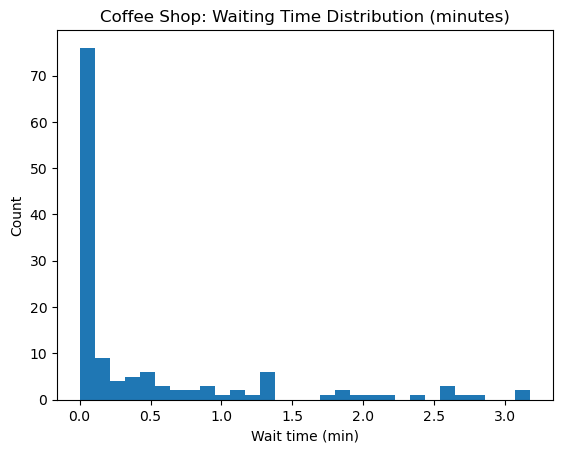

In [1]:

# DES example: Coffee Shop with 2 tellers
# -------------------------------------------------------------
# Assumptions:
# - Customer arrivals: Poisson process with rate lambda (per minute)
# - Service times: Exponential with mean 1/mu (minutes)
# - Two identical tellers (servers)
# - First-come, first-served queue
#
# We implement a basic event scheduler using heapq.
# Metrics: average waiting time, server utilization, fraction waiting > threshold

import heapq, math, random
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# Parameters (tunable)
num_hours = 3                     # simulated time window
lam = 0.7                         # arrival rate per minute (e.g., ~42 per hour)
mu = 0.6                          # service rate per minute (mean service ~1.67 min)
num_servers = 2
wait_time_threshold = 2.0         # minutes

T_end = num_hours * 60.0
t = 0.0

# Event types
ARRIVAL = 0
DEPARTURE = 1

# State
event_list = []
queue = []                        # store (arrival_time) for waiting customers
servers_busy = 0

# Metrics
arrival_times = []
start_service_times = []
departure_times = []
wait_times = []
busy_time = [0.0]*num_servers     # approximate; we treat servers symmetrically
num_wait_gt_thresh = 0

# Helper: exponential interarrival/service
def exp_time(rate):
    return np.random.exponential(1.0/rate)

# Schedule first arrival
heapq.heappush(event_list, (t + exp_time(lam), ARRIVAL, None))

# To approximate utilization per server evenly, we track "who" serves next
# by simple round-robin assignment of busy time (not perfect but adequate for demo).
server_index = 0

while event_list:
    t, etype, payload = heapq.heappop(event_list)
    if t > T_end:
        break

    if etype == ARRIVAL:
        arrival_times.append(t)

        if servers_busy < num_servers:
            # Start service immediately
            servers_busy += 1
            start_service_times.append(t)
            st = exp_time(mu)
            departure_time = t + st
            departure_times.append(departure_time)
            wait_times.append(0.0)
            if 0.0 > wait_time_threshold:
                num_wait_gt_thresh += 1

            # approximate load balance
            busy_time[server_index % num_servers] += st
            server_index += 1

            heapq.heappush(event_list, (departure_time, DEPARTURE, None))
        else:
            # Join queue
            queue.append(t)

        # Schedule next arrival
        next_arrival = t + exp_time(lam)
        if next_arrival <= T_end:
            heapq.heappush(event_list, (next_arrival, ARRIVAL, None))

    elif etype == DEPARTURE:
        if queue:
            # Someone from queue starts service
            a = queue.pop(0)
            start_service_times.append(t)
            wt = t - a
            wait_times.append(wt)
            if wt > wait_time_threshold:
                num_wait_gt_thresh += 1

            st = exp_time(mu)
            departure_time = t + st
            departure_times.append(departure_time)

            busy_time[server_index % num_servers] += st
            server_index += 1

            heapq.heappush(event_list, (departure_time, DEPARTURE, None))
        else:
            servers_busy -= 1

# Compute metrics
n_served = len(departure_times)
avg_wait = np.mean(wait_times) if wait_times else 0.0
p_wait_gt = num_wait_gt_thresh / len(wait_times) if wait_times else 0.0
utilization = [bt / T_end for bt in busy_time]

print(f"Simulated horizon: {num_hours} hours, servers={num_servers}")
print(f"Arrivals: {len(arrival_times)}  |  Served: {n_served}")
print(f"Average wait (min): {avg_wait:.2f}")
print(f"Fraction wait > {wait_time_threshold} min: {p_wait_gt:.2%}")
print("Server utilizations (approx):", [f"{u:.2%}" for u in utilization])

# Plot distribution of waits
plt.figure()
plt.hist(wait_times, bins=30)
plt.title("Coffee Shop: Waiting Time Distribution (minutes)")
plt.xlabel("Wait time (min)")
plt.ylabel("Count")
plt.show()



## 4. Agent‑Based Simulation (ABS)

**Idea:** Model individual **agents** (e.g., customers, vehicles, cells). Each agent follows simple rules and interacts with others and the environment. From these micro‑rules, **emergent** macro‑patterns appear.

**Good for:** Complex adaptive systems, pedestrian/traffic flow, epidemiology, consumer choice, and any case where heterogeneity/interaction matters.

**Key concepts**
- **Heterogeneous agents:** Each may have unique attributes or rules.
- **Local interactions:** Decisions depend on neighbourhood or perceived state.
- **Emergence:** System‑level patterns arise without central control.


Total time steps: 600
Total served: 244
Total balked: 236
Average queue lengths: q1=5.43, q2=5.33


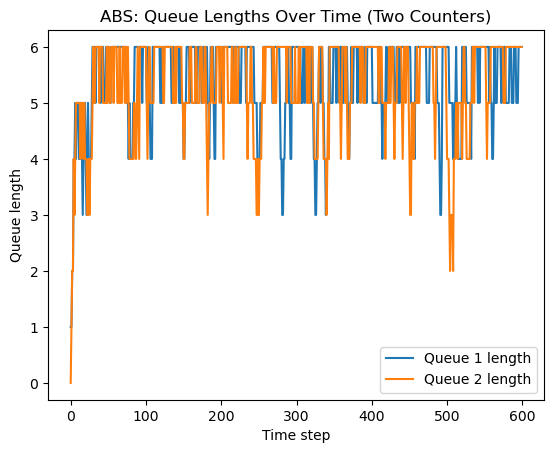

In [2]:

# ABS example: Two service counters with agent choice + balking
# -------------------------------------------------------------
# Discrete-time steps. At each step:
# 1) New customers arrive (Poisson arrivals).
# 2) Each new agent chooses the shorter queue; if both exceed a patience threshold, they balk (leave).
# 3) Each server works on the head of its queue; service times are geometric-like with small p per tick.
#
# We track queue lengths and balking. This demonstrates how simple local rules can
# balance load across counters and how patience affects throughput.

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

T = 600                # number of time steps (e.g., seconds)
arrival_rate = 0.8     # expected arrivals per time step
patience_thresh = 5    # if both queues longer than this, the agent balks
p_service = 0.2        # per-tick probability that a service completes

# State
q1, q2 = [], []        # queues as lists of remaining service times
q1_len_hist, q2_len_hist = [], []
balked = 0
served = 0

def new_service_time():
    # geometric-like: number of ticks until success ~ Geom(p), approximate by sampling
    # Equivalent: keep decrementing until event occurs with probability p each tick.
    # For initialization, start with at least 1 tick.
    # We'll simulate decrementing explicitly in the time loop.
    return 1

for t in range(T):
    # arrivals
    n_arrivals = np.random.poisson(arrival_rate)
    for _ in range(n_arrivals):
        # choose shorter queue; balk if both too long
        if len(q1) <= len(q2):
            target = 1
            other_len = len(q2)
            target_len = len(q1)
        else:
            target = 2
            other_len = len(q1)
            target_len = len(q2)

        if target_len > patience_thresh and other_len > patience_thresh:
            balked += 1
        else:
            if target == 1:
                q1.append(new_service_time())
            else:
                q2.append(new_service_time())

    # service dynamics: for each server, with prob p_service the current job (if any) completes
    # We treat one server per queue (counter 1 and counter 2).
    # If job completes, pop it and count as served.
    for q in (q1, q2):
        if q:
            if np.random.rand() < p_service:
                q.pop(0)  # job done
                served += 1

    q1_len_hist.append(len(q1))
    q2_len_hist.append(len(q2))

print(f"Total time steps: {T}")
print(f"Total served: {served}")
print(f"Total balked: {balked}")
print(f"Average queue lengths: q1={np.mean(q1_len_hist):.2f}, q2={np.mean(q2_len_hist):.2f}")

plt.figure()
plt.plot(q1_len_hist, label="Queue 1 length")
plt.plot(q2_len_hist, label="Queue 2 length")
plt.title("ABS: Queue Lengths Over Time (Two Counters)")
plt.xlabel("Time step")
plt.ylabel("Queue length")
plt.legend()
plt.show()



## 5. System Dynamics (SD)

**Idea:** Model aggregate behaviour with **stocks** (accumulations) and **flows** (rates of change), tied together by feedback loops. Time evolves continuously (we often integrate numerically).

**Good for:** Long‑term dynamics, policy stress tests, and feedback‑heavy systems (supply chains, ecosystems, macroeconomy, project management).


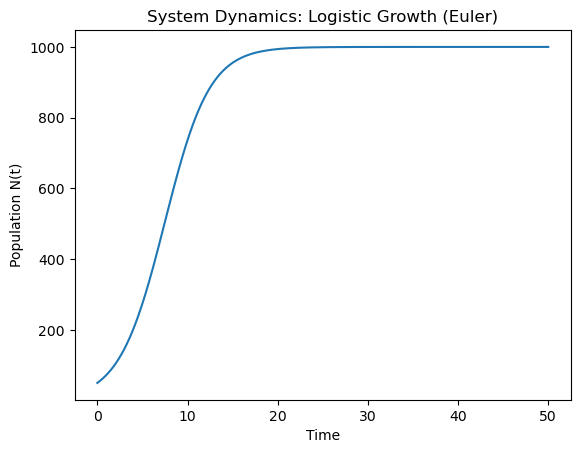

In [3]:

# SD example: Logistic growth dN/dt = r*N*(1 - N/K)
# --------------------------------------------------
# We use simple Euler integration. This demonstrates stock (N) and flows (growth).

import numpy as np
import matplotlib.pyplot as plt

r = 0.4       # intrinsic growth rate
K = 1000.0    # carrying capacity
N0 = 50.0     # initial population

T = 50.0
dt = 0.1
steps = int(T/dt)

t = np.linspace(0, T, steps+1)
N = np.zeros(steps+1)
N[0] = N0

for i in range(steps):
    dN = r * N[i] * (1 - N[i]/K)
    N[i+1] = N[i] + dt * dN

plt.figure()
plt.plot(t, N)
plt.title("System Dynamics: Logistic Growth (Euler)")
plt.xlabel("Time")
plt.ylabel("Population N(t)")
plt.show()



## 6. Monte Carlo (MC) Simulation

**Idea:** Use repeated random sampling to propagate uncertainty through a model and estimate distributions of outcomes (e.g., cost, time, risk).

**Good for:** Risk assessment, project timelines, pricing/valuation, reliability, and any scenario with uncertain inputs.


Estimated P(finish <= 12.0 days): 59.27%
Mean total duration: 11.67 days (std 1.63)


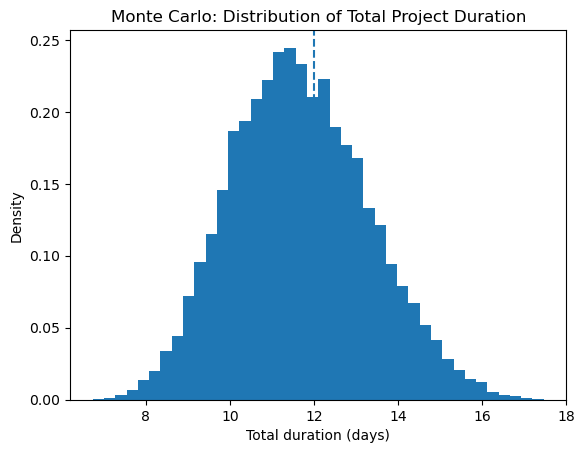

In [4]:

# MC example: Probability a small project finishes before a deadline
# -----------------------------------------------------------------
# Three serial tasks with uncertain durations (triangular distributions).
# Estimate P(total_duration <= deadline).

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Triangular parameters (min, mode, max) in days
task_params = [
    (2.0, 3.0, 6.0),   # Task A
    (1.0, 2.0, 4.0),   # Task B
    (3.0, 5.0, 9.0)    # Task C
]

deadline = 12.0
N = 20_000

samples = []
for _ in range(N):
    total = 0.0
    for (a, m, b) in task_params:
        total += np.random.triangular(a, m, b)
    samples.append(total)

samples = np.array(samples)
prob_on_time = np.mean(samples <= deadline)

print(f"Estimated P(finish <= {deadline} days): {prob_on_time:.2%}")
print(f"Mean total duration: {samples.mean():.2f} days (std {samples.std():.2f})")


plt.figure()
plt.hist(samples, bins=40, density=True)
plt.axvline(deadline, linestyle='--')
plt.title("Monte Carlo: Distribution of Total Project Duration")
plt.xlabel("Total duration (days)")
plt.ylabel("Density")
plt.show()



## 7. Comparison & Selection

| Simulation Type | Best For | Key Limitations |
|---|---|---|
| **Discrete‑Event (DES)** | Queues, process flow, resource contention | Can be intensive for very large systems; event logic can get complex |
| **Agent‑Based (ABS)** | Complex adaptive systems, heterogeneous behaviour | Validation is hard; can be computationally heavy |
| **System Dynamics (SD)** | Long‑term feedback and policy analysis | Aggregation may hide important micro‑level effects |
| **Monte Carlo (MC)** | Uncertainty and risk analysis across many inputs | Quality depends on input distributions and correlations |

**Selection tips**  
- Match the model to the **questions** you need to answer.  
- DES for **operations** and resource contention, ABS for **micro‑rules & emergence**, SD for **feedback/policy**, MC for **uncertainty propagation**.  
- Hybrid models are common in practice.
